In [1]:
# Refer to path of package
import sys
sys.path.append('/Users/watcharapongwongrattanasirikul/Documents/Git/Jupyter/my_env/lib/python3.8/site-packages')

In [2]:
# Import Lib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import re
from random import choices, randint, randrange, uniform

In [3]:
from ml_helper import MlHelper
from eda_helper import EdaHelper
from sampling_helper import SamplingHelper
from impute_helper import ImputeHelper
from impute_helper import imputation_strategy
from ml_helper import model_type
from ml_helper import resampler_type
from ml_helper import scaler_type

In [4]:
file_path = '/Users/watcharapongwongrattanasirikul/Documents/Git/predictive-maintenance/train_timeseries.csv'

df = pd.read_csv(file_path)
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
# Rename of columns
df = df.rename(columns={
    'Air temperature [K]':'AirTemp',
    'Process temperature [K]':'ProcessTemp',
    'Rotational speed [rpm]':'RotationalSpeed',
    'Torque [Nm]':'Torque',
    'Tool wear [min]': 'ToolWear',
    'Machine failure':'MF'
})
df.head()

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


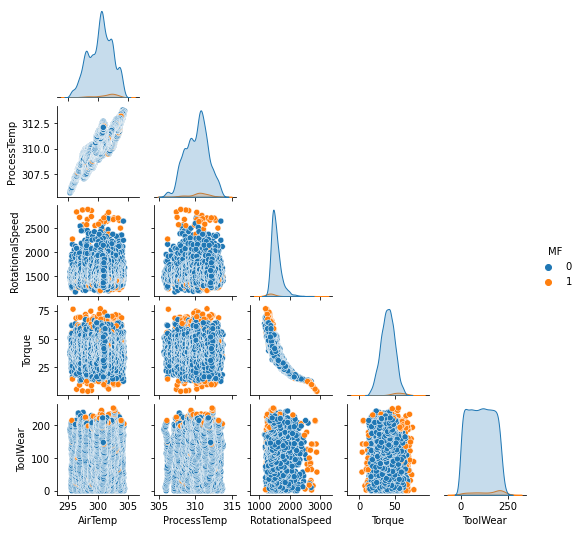

In [14]:
# Pair plot

df_pairplot = df.drop(['UDI', 'Product ID', 'Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, )

sns.pairplot(df_pairplot, hue='MF', corner=True,  height=1.5)

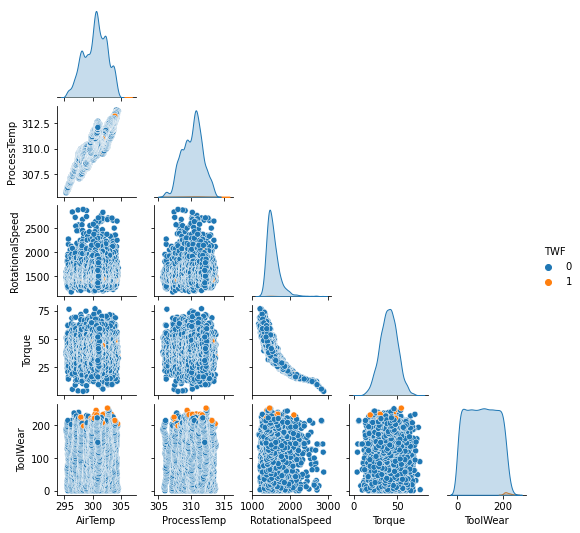

In [15]:
# Pair plot

df_pairplot = df.drop(['UDI', 'Product ID', 'Type', 'MF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, )

sns.pairplot(df_pairplot, hue='TWF', corner=True,  height=1.5)

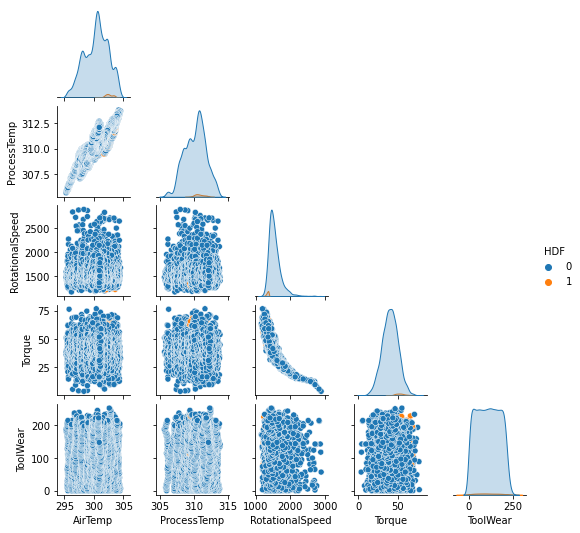

In [16]:
# Pair plot

df_pairplot = df.drop(['UDI', 'Product ID', 'Type', 'MF', 'TWF', 'PWF', 'OSF', 'RNF'], axis=1, )

sns.pairplot(df_pairplot, hue='HDF', corner=True,  height=1.5)

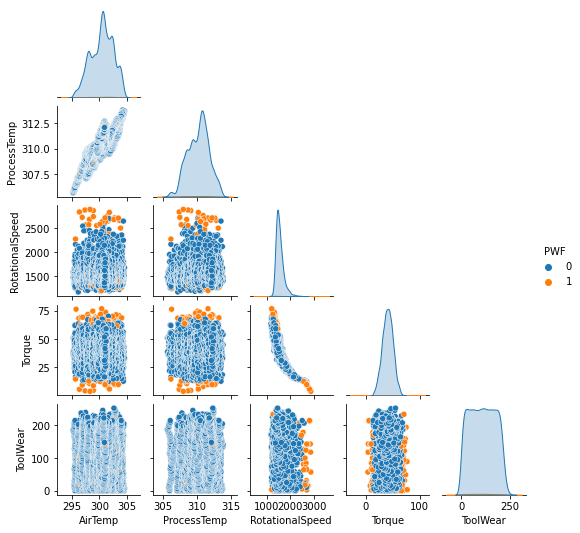

In [17]:
# Pair plot

df_pairplot = df.drop(['UDI', 'Product ID', 'Type', 'MF', 'TWF', 'HDF', 'OSF', 'RNF'], axis=1, )

sns.pairplot(df_pairplot, hue='PWF', corner=True,  height=1.5)

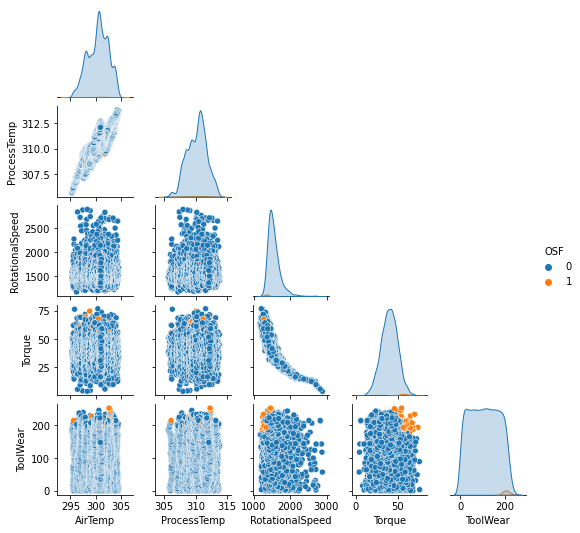

In [18]:
# Pair plot

df_pairplot = df.drop(['UDI', 'Product ID', 'Type', 'MF', 'TWF', 'PWF', 'HDF', 'RNF'], axis=1, )

sns.pairplot(df_pairplot, hue='OSF', corner=True,  height=1.5)

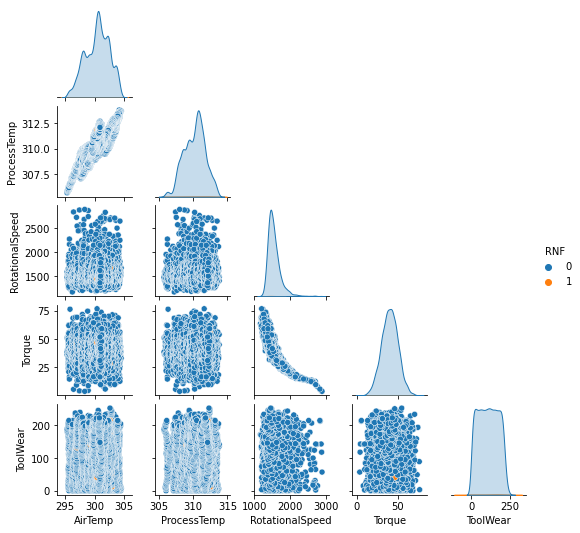

In [19]:
# Pair plot

df_pairplot = df.drop(['UDI', 'Product ID', 'Type', 'MF', 'TWF', 'PWF', 'HDF', 'OSF'], axis=1, )

sns.pairplot(df_pairplot, hue='RNF', corner=True,  height=1.5)

### Feature Engineering

In [ ]:
def log_feature(val):
    result = np.log(val)
    
    if result not in [np.inf, -np.inf, np.NaN]:
        return result
    else:
        return 0

In [ ]:
def devide_feature(val):
    if val[1] == 0:
        return 0
    else:
        return val[0]/val[1]

In [ ]:
# Add log feature
df['AirTempLog'] = (df['AirTemp']).transform(log_feature)
df['ProcessTempLog'] = (df['ProcessTemp']).transform(log_feature)
df['RotationalSpeedLog'] = (df['RotationalSpeed']).transform(log_feature)
df['TorqueLog'] = (df['Torque']).transform(log_feature)
df['ToolWearLog'] = (df['ToolWear']).transform(log_feature)

In [ ]:
# Add devided feature

df['AirTempProcessTempDevided'] = (df[['AirTemp', 'ProcessTemp']]).apply(devide_feature, axis=1)
df['TorqueRotationalSpeedDevided'] = (df[['Torque', 'RotationalSpeed']]).apply(devide_feature, axis=1)

In [ ]:
# Add square feature

df['AirTempSq'] = (df['AirTemp']) * (df['AirTemp'])
df['ProcessTempSq'] = (df['ProcessTemp']) * (df['ProcessTemp'])
df['RotationalSpeedSq'] = (df['RotationalSpeed']) * (df['RotationalSpeed'])
df['TorqueSq'] = (df['Torque']) * (df['Torque'])
df['ToolWearSq'] = (df['ToolWear']) * (df['ToolWear'])

In [ ]:
# This function use to encode data point to be class label
# a = data less than or equal percentile 25
# b = data less than or equal percentile 50
# c = data less than or equal percentile 75
# d = data greater than percentile 75

def encode_feature(df):
    
    mean = np.mean(df)
    std = np.std(df)
    
    encoder_list = []
    
    for data_point in df:
        
        if data_point <= (mean - (3*std)):
            encoder_list.append(1)
            continue
        
        if data_point <= (mean - (2*std)):
            encoder_list.append(2)
            continue
            
        if data_point <= (mean - (1*std)):
            encoder_list.append(3)
            continue
            
        if data_point <= mean:
            encoder_list.append(4)
            continue
            
        if data_point <= (mean + (1*std)):
            encoder_list.append(5)
            continue
            
        if data_point <= (mean + (2*std)):
            encoder_list.append(6)
            continue       
                        
        encoder_list.append(7)

    return encoder_list

In [ ]:
df['Airtemp_Class'] = encode_feature(df['AirTemp'])
df['ProcessTemp_Class'] = encode_feature(df['ProcessTemp'])
df['Rotational_Class'] = encode_feature(df['RotationalSpeed'])
df['Torque_Class'] = encode_feature(df['Torque'])
df['ToolWear_Class'] = encode_feature(df['ToolWear'])

In [ ]:
df.head(2)

### Feature Selection

In [ ]:
label = 'TWF'



In [ ]:
unuse_column = ['UDI', 'Product ID', 'Type']
drop_label = ['MF', 'HDF', 'PWF', 'OSF', 'RNF']
drop_column = unuse_column + drop_label

In [ ]:
df_check_feature = df.drop(drop_column, axis=1)

importance_features_twf = EdaHelper.get_feature_importance(df_check_feature, label, 0.0)
importance_features_twf

In [ ]:
drop

In [ ]:
df.head(5)

### Impute Data

In [ ]:
# Drop unused data
df.drop(['UDI', 'Product ID', 'Type'], axis=1, inplace=True)
df.head(5)

In [ ]:
y = df['MF']
x = df.drop(['MF'], axis=1)

In [ ]:
# Under Sampling

x_rs_under, y_rs_under = SamplingHelper.under_sampling(x, y)
df_under_sampling = EdaHelper.get_dataframe_xy(x_rs_under, y_rs_under)
df_under_sampling.head(5)

In [ ]:
# Over Sampling

x_rs_over, y_rs_over = SamplingHelper.over_sampling(x, y)
df_over_sampling = EdaHelper.get_dataframe_xy(x_rs_over, y_rs_over)
df_over_sampling.head(5)

In [ ]:
# Smote Sampling

x_rs_smote, y_rs_smote = SamplingHelper.smote_sampling(x, y)
df_smote_sampling = EdaHelper.get_dataframe_xy(x_rs_smote, y_rs_smote)
df_smote_sampling.head(5)

In [ ]:
# Smote-Tomek Sampling

x_rs_smotetomek, y_rs_smotetomek = SamplingHelper.smotetomek_sampling(x, y)
df_smotetomek_sampling = EdaHelper.get_dataframe_xy(x_rs_smotetomek, y_rs_smotetomek)
df_smotetomek_sampling.head(5)

In [ ]:
plot_class_distribution(df_smotetomek_sampling,'MF')

In [ ]:
def plot_class_distribution(df, label):
    c = ['Grey', 'Red']
    df.groupby('MF').size().plot(kind="bar", color=c)
    plt.title('Class Distribution', fontsize=18)
    plt.yticks(np.arange(0, 12000, 2000))
    # plt.grid()

    for index, value in enumerate(df.groupby(label).size()):
        c_label = ''
        if index == 0:
            c_label = 'Black'
        else:
            c_label = 'Red'
        plt.text(index - 0.1, value + 1000, str(value), color=c_label, fontsize=14)

    sns.despine()

In [ ]:
plot_class_distribution(df, 'MF')

In [ ]:
import math

def plot_scatter_features(df):
    col = 5
    row = math.ceil(int(len(df.columns))/5)
    color_map = {0:'grey', 1:'red'}
    
    fig, axs = plt.subplots(row, col, sharex=True, figsize=(col*3.5,row*1.75), tight_layout=True)

    axs = axs.ravel()
    
    for idx, col in enumerate(df.columns):
        sns.scatterplot(ax=axs[idx], x=range(df.shape[0]), y=df[col], c=df['MF'].map(color_map),  alpha=0.3 )
    
    sns.despine()

In [ ]:
df.head(2)

In [ ]:
df_plot = df.drop(['Product ID'], axis=1)

In [ ]:
plot_scatter_features(df_plot)

In [ ]:
import math

def plot_boxplot_features(df, label):
    col = 5
    row = math.ceil(int(len(df.columns))/5)
    color_map = {0:'grey', 1:'red'}
    
    fig, axs = plt.subplots(row, col, sharex=True, figsize=(col*3.5,row*1.75), tight_layout=True)

    axs = axs.ravel()
    
    for idx, col in enumerate(df.columns):
        sns.boxplot(ax=axs[idx], x=label, y=col, data=df)
    
    sns.despine()

In [ ]:
df_box_plot = df_plot.drop(['Type', 'UDI'], axis=1)
df_box_plot.head(2)

In [ ]:
plot_boxplot_features(df_box_plot, 'MF')

In [ ]:
import math

def plot_line_features(df, label):
    col = 5
    row = math.ceil(int(len(df.columns))/5)
    color_map = {0:'grey', 1:'red'}
    
    fig, axs = plt.subplots(row, col, sharex=True, figsize=(col*3.5,row*1.75), tight_layout=True)

    axs = axs.ravel()
    
    for idx, col in enumerate(df.columns):
        sns.lineplot(ax=axs[idx], x=range(df.shape[0]), y=df[col],color='cornflowerblue',  alpha=1 )
    
    sns.despine()

In [ ]:
plot_line_features(df_box_plot, 'MF')

In [ ]:
df.describe()

In [ ]:
df['MF'].count()

In [ ]:
count

In [ ]:
def get_moving_average(df, window_size=10):
    windows = df.rolling(window_size)
    moving_average = windows.mean()
    moving_averages_list = moving_average.tolist()
    final_list = moving_averages_list[window_size - 1:]
    
    return(final_list)

In [ ]:
def plot_feature_class(df, feautures, label, window_size=10):
    fig, ax = plt.subplots(len(feautures)+1, 1, figsize=(42,15))
    sns.lineplot(ax=ax[0], x=range(df.shape[0]), y=label, data=df, alpha=0.5, color='red' )
    
    
    for idx, feature in enumerate(feautures):
        sns.lineplot(ax=ax[idx+1], x=range(df.shape[0]), y=feautures[idx], data=df, alpha=0.5 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[217.8 for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(window_size-1, df.shape[0]), y=get_moving_average(df[feature], window_size), alpha=0.5 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + df[feature].std() for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - df[feature].std() for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + (2 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - (2 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + (3 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - (3 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )

In [ ]:
df_feature = df.drop(['UDI', 'Product ID', 'Type', 'MF', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF' ], axis=1)
df_feature.head(2)

In [ ]:
df_feature_scale = MlHelper.scale_data(df_feature, scaler_type.normalizer)
df_scale =  pd.concat([pd.DataFrame(data=df['MF']), pd.DataFrame(data=df['TWF']),pd.DataFrame(data=df['HDF']),pd.DataFrame(data=df['PWF']),pd.DataFrame(data=df['OSF']),pd.DataFrame(data=df['RNF']), pd.DataFrame(data=df_feature_scale)], axis=1, sort=False )
columns = ['MF', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'AirTemp', 'ProcessTemp', 'RotationalSpeed', 'Torque', 'ToolWear']
df_scale.columns = columns
df_scale.head(2)

In [ ]:
df_scale['Tor-Rot'] = df_scale['Torque'] - df_scale['RotationalSpeed']
df_scale.head(2)

In [ ]:
df.columns

In [ ]:
df_1000 = df.iloc[4000:6000,:]

In [ ]:
df_twf_failed = df[df['TWF']==1]
toolwear = df_twf_failed['ToolWear']

In [ ]:
df_check = df[df['ToolWear'] >= 217.85]

In [ ]:
df_check['TWF'].sum()

In [ ]:
plot_feature_class(df_1000, ['ToolWear','RotationalSpeed','Torque','AirTemp','ProcessTemp'], 'TWF', 10)

# Genetic Algorithms to find the prediction pattern

## encoder function

In [ ]:
# This function use to encode data point to be class label
# a = data less than or equal percentile 25
# b = data less than or equal percentile 50
# c = data less than or equal percentile 75
# d = data greater than percentile 75

def encode_feature(df):
    
    mean = np.mean(df)
    std = np.std(df)
    
    encoder_list = []
    
    for data_point in df:
        
        if data_point <= (mean - (3*std)):
            encoder_list.append('a')
            continue
        
        if data_point <= (mean - (2*std)):
            encoder_list.append('b')
            continue
            
        if data_point <= (mean - (1*std)):
            encoder_list.append('c')
            continue
            
        if data_point <= mean:
            encoder_list.append('d')
            continue
            
        if data_point <= (mean + (1*std)):
            encoder_list.append('e')
            continue
            
        if data_point <= (mean + (2*std)):
            encoder_list.append('f')
            continue       
                        
        encoder_list.append('g')

    return encoder_list

In [ ]:
df_torque = df['Torque']
test_encoder = encode_feature(df_torque)
test_encoder[:10]

### Generate the random genome by specific length

In [ ]:
def generate_genome(length:int):
    
    genome = []
    previous_gene = ''
    or_logic = False
    count_or = 0
    
    for i in range(length):
        
        # First character should not be symbol
        if i == 0:
            next_gene = choices(['a','b','c','d','e','f','g'], k=1)
            genome = genome + next_gene
            previous_gene = next_gene
            continue
            
        # Last character should not be symbol
        if i == (length-1):
            next_gene = choices(['a','b','c','d','e','f','g'], k=1)
            genome = genome + next_gene
            previous_gene = next_gene
            continue
            
        # If previous character is symbol then next character should not be symbol
        if previous_gene[0] == '.*' or previous_gene[0] == '|':
            next_gene = choices(['a','b','c','d','e','f','g'], k=1)
            genome = genome + next_gene
            
            if previous_gene[0] == '|':
                or_logic = True
                count_or = 2
                
            previous_gene = next_gene
            continue
                
        if count_or > 0:
            next_gene = choices(['a','b','c','d','e','f','g'], k=1)
            genome = genome + next_gene
            previous_gene = next_gene
            count_or = count_or - 1
            continue
        
        next_gene = choices(['a','b','c','d','e','f','g','.*','|'], k=1)            
        genome = genome + next_gene
        previous_gene = next_gene
    
    return genome

In [ ]:
test_genome = generate_genome(10)
test_genome

### Generate the population

In [ ]:
def generate_population(size, genome_lenght):
    return [generate_genome(genome_lenght) for _ in range(size)]

In [ ]:
test_population = generate_population(3, 5)
test_population

### Get expression

In [ ]:
def get_expression(data):
    
    reg_result = ""
    or_flag = False
    
    for idx, i in enumerate(data):
        
        if i == '|' and reg_result == "":
            raise Exception("The symbol '|' can't be the first parameter")
            
        if i == '|' and (idx + 1) == len(data):
             raise Exception("The symbol '|' can't be the last parameter")
        
        if i in ('a', 'b', 'c', 'd','e','f','g','.*') and or_flag == False:
            reg_result = reg_result + i
            buf = i
            continue
        
        if i in ('a', 'b', 'c', 'd','e','f','g','.*') and or_flag == True:
            reg_result = reg_result + f"{i}]"
            or_flag = False
            continue
            
        if or_flag == True and (i == '|' or i == '.*'):
            reg_result = reg_result + 'd'
            continue
            
        if i == '|':
            reg_result = reg_result[0:(len(reg_result)- len(buf))]
            reg_result = reg_result + f"[{buf}|"
            or_flag = True
            continue
 
    return reg_result

In [ ]:
test_expression = get_expression(test_genome)

print(test_genome)
print(test_expression)

### Get the pattern

In [ ]:
def find_pattern(encoder_result, df_state, window_size=20):
    
    # variable setting
    start = 0
    end = window_size
    
    number_round = int(len(encoder_result)/window_size)

    pattern_list = []
    
    for i in range(0, number_round):
        # Find the next period will have the fail case or not
        fail_next_period = list(df_state[end:end+window_size])
        is_fail_next_period = sum(fail_next_period)>0
        
        if is_fail_next_period == True:
            current_pattern = ''.join(encoder_result[start:end])
            pattern_list.append(current_pattern)
            
        start += window_size
        end += window_size

    return pattern_list
    

In [ ]:
df_torque = df['Torque']
encode_torque = encode_feature(df_torque)

In [ ]:
df_PWF = df['PWF']

In [ ]:
expected_pattern = find_pattern(encode_torque, df_PWF)

In [ ]:
print('a b c d e f')
for i in expected_pattern:
    print(i.count('a') + i.count('b') + i.count('c'), i.count('e') + i.count('f'))

In [ ]:
def test_pattern(encoder_result, df_state, window_size=20):
    # variable setting
    start = 0
    end = window_size
    
    number_round = int(len(encoder_result)/window_size)

    pattern_list = []
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(0, number_round):
        
        current_pattern = ''.join(encoder_result[start:end])
        
        if current_pattern.count('f') + current_pattern.count('e') >= 13:
            predict_fail = True
        else:
            predict_fail = False
        
        # Find the next period will have the fail case or not
        fail_next_period = list(df_state[end:end+window_size])
        is_fail_next_period = sum(fail_next_period)>0
        
        if is_fail_next_period == True:
            current_pattern = ''.join(encoder_result[start:end])
            pattern_list.append(current_pattern)
            
        # Calculate Fitness Score
        if  predict_fail == True and is_fail_next_period == True:
            TP += 1
            
        if predict_fail == True and is_fail_next_period == False:
            FP += 1
            
        if predict_fail == False and is_fail_next_period == False:
            TN += 1
            
        if predict_fail == False and is_fail_next_period == True:
            FN += 1
            
        start += window_size
        end += window_size

    print(f'TP:{TP}, FP:{FP}, TN:{TN}, FN:{FN}')
    
    return True

In [ ]:
test_pattern(encode_torque, df_PWF)

### Calculate the fitness score

In [ ]:
def fitness(genome, encoder_result, df_state, window_size=20, is_print_counting = False):
    
    # variable setting
    fitness_score = 0
    start = 0
    end = window_size
    number_round = int(len(encoder_result)/window_size)-1
    has_match_pattern = False
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    # Get reg function from genome
    reg_expression = get_expression(genome)
    use_reg_expression = '.*' + reg_expression + '.*'
    
    # Counting
    count_predict_true = 0
    count_predict_false = 0
    count_not_match = 0
    
    predict_list = []
    
    # Iterate over the data by specific period
    for i in range(0, number_round):
        
        # Predict the next period by pattern of the current period
        current_pattern = ''.join(encoder_result[start:end])
        matched = re.search(use_reg_expression, current_pattern)
        
        #print(f'pattern {current_pattern} with reg {reg_expression} is match {matched}')
        
        if matched is not None:
            predict_fail = True
            
            if has_match_pattern == False:
                has_match_pattern = True
        else:
            predict_fail = False
        
        # Find the next period will have the fail case or not
        fail_next_period = list(df_state[end:end+window_size])
        is_fail_next_period = sum(fail_next_period)>0
    
        # Calculate Fitness Score
        if  predict_fail == True and is_fail_next_period == True:
            TP += 1
            
        if predict_fail == True and is_fail_next_period == False:
            FP += 1
            
        if predict_fail == False and is_fail_next_period == False:
            TN += 1
            
        if predict_fail == False and is_fail_next_period == True:
            FN += 1
            
            

        start += window_size
        end += window_size
        
    if (TP+FN) == 0:
        recall = 0
    else:
        recall = TP/(TP + FN)
    
    if (TP+FP) == 0:
        precision = 0
    else:
        precision = TP/(TP+FP)
    
    if (precision+recall) == 0:
        fitness_score = 0
    else:
        fitness_score = 2 * ((precision * recall)/(precision+recall))
    
    if is_print_counting == True:
        print(f'Count True: {count_predict_true}, False: {count_predict_false}, Not match: {count_not_match}')
    
    return(fitness_score)

In [ ]:
df_PWF = df['PWF']
df_torque = df['Torque']
encode_torque = encode_feature(df_torque)

In [ ]:
test_genome = generate_genome(5)

score = fitness(test_genome, encode_torque, df_PWF, 40)
print(score)

### Selection Pair

In [ ]:
def selection_pair(population, weights, number=10):
    return choices(
        population=population,
        weights= weights,
        k=number
    )

In [ ]:
weights = [1, 0, 0]
selected_genome = selection_pair(test_population, weights)
selected_genome

### Cross Over

In [ ]:
def single_point_cross_over(genome1, genome2):
    if len(genome1) != len(genome2):
        print(genome1)
        print(genome2)
        raise ValueError("Genomes 1 and 2 must be of same length")
        
    length = len(genome1)
    
    if length < 2:
        return genome1, genome2
    
    position = randint(1, length-1)
    return genome1[0:position] + genome2[position:], genome2[0:position] + genome1[position:]

In [ ]:
test_genome1 = [1, 2, 3, 4, 5, 6, 7 ,8, 9 , 10]
test_genome2 = [10, 9 , 8, 7, 6, 5, 4, 3, 2, 1]

test_genome11, test_genome21 = single_point_cross_over(test_genome1, test_genome2)
print(test_genome11)
print(test_genome21)

### Mutation

In [ ]:
def mutation(genome, number=1):
    for _ in range(number):
        index = randrange(len(genome))
        genome[index] = choices(['a','b','c','d'], k=1)[0]
        
        return genome

In [ ]:
test_genome3 = [1, 2, 3, 4, 5, 6, 7 ,8, 9 , 10]
new = mutation(test_genome3)
new

### Evolution

In [ ]:
def run_evolution(initial_population, encoder_feature, df_state, generation_limit=100):
    
    # Parameter setting
    pop_crossover_threshold = 0.80
    pop_mutation_threshold = 0.02
    
    population = initial_population
    
    for i in range(generation_limit):
        
        # 1. Calculate fitness score for all population
        fitness_scores = [fitness(genome, encoder_feature, df_state,20, False) for genome in population]

        max_score = max(fitness_scores)
        
        #if i in (1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000):
        print(f'round {i} has max score {max_score}.')  #The whole score list {fitness_scores}')

        # 2. Evaluation
        if max_score >= 10:
            population_and_score = list(zip(score, population))
            sorted_population_and_score = population_and_score.sort(reverse=True)
            top_population = sorted_population_and_score[0]
            print(f"The best population is {top_population[1]} with score {top_population[0]}")
            break

        # 3. Select new population
        adjust_score = [i for i in fitness_scores]
        weight_selection = [i/sum(adjust_score) for i in adjust_score] # Weight for random new population
        new_population = selection_pair(population, weight_selection, 10)
        
        # 4. Crossover
        pop_crossover = uniform(0, 1)

        if pop_crossover <= pop_crossover_threshold:
            
            offspring1, offspring2 = single_point_cross_over(new_population[0], new_population[1])
            offspring3, offspring4 = single_point_cross_over(new_population[2], new_population[3])
            offspring5, offspring6 = single_point_cross_over(new_population[4], new_population[5])
            offspring7, offspring8 = single_point_cross_over(new_population[6], new_population[7])
            offspring9, offspring10 = single_point_cross_over(new_population[8], new_population[9])

            new_population = [offspring1, offspring2, offspring3, offspring4, offspring5, offspring6, offspring7, offspring8, offspring9, offspring10]
    
        # 5. Mutation
        for idx, genome in enumerate(new_population):
            pop_mutation = uniform(0, 1)
            if pop_mutation <= pop_mutation_threshold: 
                new_population[idx] = mutation(genome)
        
        population = new_population
        
        # 6. Exist loop when exceed the generation_limit
        if i == generation_limit - 1:
            fitness_scores = [fitness(genome, encoder_feature, df_PWF) for genome in population]
            population_and_score = list(zip(fitness_scores, population))
            population_and_score.sort(reverse=True)
            top_population = population_and_score[0]
            print(f"Last round the best population is {top_population[1]} with score {top_population[0]}")
            
    return(fitness_scores)
        

In [ ]:
df_feature = df_scale['Tor-Rot']
feature_encoded = encode_feature(df_feature) 

In [ ]:
df_PWF = df['PWF']

In [ ]:
population = generate_population(10, 5)

score = run_evolution(population, encode_torque, df_PWF, 20000)

In [ ]:
a = ['A', 'B', 'C']
b = [3, 2, 1]

result = zip(b, a)
c =list(result)

In [ ]:
c

In [ ]:
c.sort(reverse=False)
c

In [ ]:
c[0][1]

In [ ]:
encode_torque

In [ ]:
for i in scores:
    print(type(i))

In [ ]:
weight = [i/sum(scores) for i in scores]
weight

In [ ]:
a1

In [ ]:
a2 = mutation(a1)

In [ ]:
a2

In [ ]:
a = generate_genome(10)
b = generate_genome(10)

In [ ]:
a1, b1 = single_point_cross_over(a, b)

In [ ]:
print(a)
print(b)
print(a1)
print(b1)

In [ ]:
fitness(test_genome, encode_torque, 'a')

In [ ]:
population_test = generate_population(10, 10)

In [ ]:
p = selection_pair(population_test, fitness)

In [ ]:
p

In [ ]:
a = generate_genome(10)
a

In [ ]:
get_expression(a)

In [ ]:
# Test rolling windows

test_list = [1,2,3,4,5,7,8,9,10]

windows = pd.DataFrame(test_list).rolling(2)

for idx, i in enumerate(windows):
    print(list(i[0]))

In [ ]:
a = [1,2,3,4]

In [ ]:
weight = [i/sum(a) for i in a]

In [ ]:
weight